In [3]:
# Data Processing

import pandas,numpy
import pymyami
from matplotlib import pyplot

modern = numpy.array([0.0102821,0.0528171,0.0282352]).reshape(-1,1)  # Ca, Mg, SO4

# Load Zeebe + Tyrrell parameters and dictionarify
zeebe_parameters_dataframe = pandas.read_csv('./../data/ZeebeTyrrell.csv',index_col=0)
zeebe_parameters = {k: zeebe_parameters_dataframe[k].values.reshape(-1,1) for k in zeebe_parameters_dataframe.columns}

# Function for the Zeebe + Tyrrell sensitivity approach
# Purloined from Oscar
def zeebe_tyrrell(Ca,Mg,SO4):
    target = numpy.vstack([Ca,Mg,SO4])    
    relative_concentration = (target/modern)-1
    
    return {k: 1 + (zeebe_parameters[k]*relative_concentration).sum(axis=0) for k in zeebe_parameters}

# Load the MyAMI data
myami = pandas.read_csv("./../data/MyAMI.csv",index_col=0)
myami.columns = ['T','S','Ca','Mg','KspC','K1','K2','KW','KB','KspA','K0','KS']

# Do the calculation with each method with results in dictionaries
# Order is Salinity,Temperature,Magnesium,Calcium for Zeebe
zeebe_dictionary = zeebe_tyrrell(Ca=myami.Ca.values,Mg=myami.Mg.values,SO4=numpy.array([0.0282352]*len(myami.Ca.values)))
pymyami_dictionary = pymyami.calculate_seawater_correction(Sal=myami.S.values,TempC=myami['T'].values,Ca=myami.Ca.values,Mg=myami.Mg.values)
myami_dictionary = {k: myami[k].values for k in myami}

# Matrixify the dictionaries
zeebe_matrix = {k: numpy.reshape(zeebe_dictionary[k],(5,5,5,5)) for k in zeebe_dictionary}
pymyami_matrix = {k: numpy.reshape(pymyami_dictionary[k],(5,5,5,5)) for k in pymyami_dictionary}
myami_matrix = {k: numpy.reshape(myami_dictionary[k],(5,5,5,5)) for k in myami_dictionary}

In [4]:
# Plot configuration

K_list = ["K0","K1","K2","KW","KB","KS","KspC","KspA"]

# Y limits for the plots - manually tuned
calcium_magnesium_heights = {"K0":[0.98,1.02],
                             "K1":[0.95,1.05],
                             "K2":[0.4,1.8],
                             "KW":[0.4,1.1],
                             "KB":[0.8,1.5],
                             "KS":[0.8,1.2],
                             "KspC":[0.3,2.0],
                             "KspA":[0.3,2.0]}
temperature_salinity_heights = {"K0":[1.0,1.0015],
                                "K1":[0.995,1.005],
                                "K2":[0.9,0.96],
                                "KW":[1.07,1.09],
                                "KB":[0.97,0.98],
                                "KS":[0.99,1.0],
                                "KspC":[0.85,1.0],
                                "KspA":[0.85,1.0]}

colours = {"pymyami":"#853838",
           "myami":"#4d62c2",
           "zeebe":"#d1ce2d"}

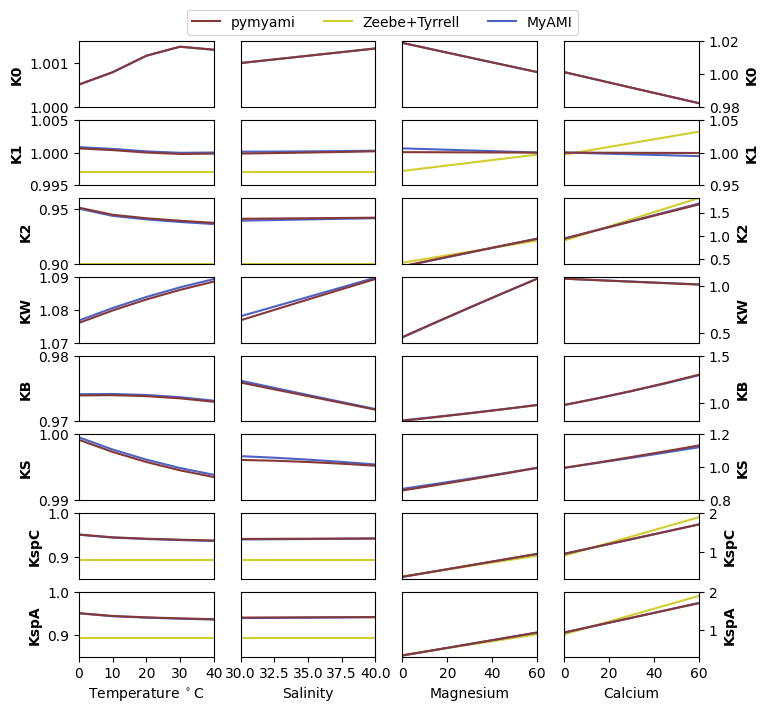

In [5]:
# Plotting

figure,axes = pyplot.subplots(len(pymyami_dictionary),4,figsize=(8,8))
for index,k in enumerate(K_list):
    # Temperature slices
    temperatures = myami["T"].unique()
    axes[index][0].plot(temperatures,pymyami_matrix[k][2,:,4,0],color=colours["pymyami"],zorder=1,label="pymyami")
    if k in zeebe_dictionary:
        axes[index][0].plot(temperatures,zeebe_matrix[k][2,:,4,0],color=colours["zeebe"],zorder=0,label="Zeebe+Tyrrell")
    if k in myami_dictionary:
        axes[index][0].plot(temperatures,myami_matrix[k][2,:,4,0],color=colours["myami"],zorder=0,label="MyAMI")

    axes[index][0].set_xlim((0,40))
    axes[index][0].ticklabel_format(useOffset=False)
    if k in temperature_salinity_heights:
        axes[index][0].set_ylim((temperature_salinity_heights[k][0],temperature_salinity_heights[k][1]))
    axes[index][0].set_ylabel(k,fontweight='bold')
    if index!=(len(pymyami_dictionary)-1):
        axes[index][0].set_xticks([])
    else:
        axes[index][0].set_xticks([0,10,20,30,40])
        axes[index][0].set_xlabel("Temperature $^\circ$C")

    # Salinity slice
    salinities = myami["S"].unique()
    axes[index][1].plot(salinities,pymyami_matrix[k][:,2,4,0],color=colours["pymyami"],zorder=1)
    if k in zeebe_dictionary:
        axes[index][1].plot(salinities,zeebe_matrix[k][:,2,4,0],color=colours["zeebe"],zorder=0)
    if k in myami_dictionary:
        axes[index][1].plot(salinities,myami_matrix[k][:,2,4,0],color=colours["myami"],zorder=0)

    axes[index][1].set_xlim((30,40))
    axes[index][1].ticklabel_format(useOffset=False)
    if k in temperature_salinity_heights:
        axes[index][1].set_ylim((temperature_salinity_heights[k][0],temperature_salinity_heights[k][1]))
    axes[index][1].set_yticks([])
    if index!=(len(pymyami_dictionary)-1):
        axes[index][1].set_xticks([])
    else:
        axes[index][1].set_xticks([30,32.5,35,37.5,40])
        axes[index][1].set_xlabel("Salinity")

    # Magnesium slice
    magnesiums = myami["Mg"].unique()
    axes[index][2].plot(magnesiums*1e3,pymyami_matrix[k][2,2,:,0],color=colours["pymyami"],zorder=1)
    if k in zeebe_dictionary:
        axes[index][2].plot(magnesiums*1e3,zeebe_matrix[k][2,2,:,0],color=colours["zeebe"],zorder=0)
    if k in myami_dictionary:
        axes[index][2].plot(magnesiums*1e3,myami_matrix[k][2,2,:,0],color=colours["myami"],zorder=0)

    axes[index][2].set_xlim((0,60))
    axes[index][2].ticklabel_format(useOffset=False)
    if k in calcium_magnesium_heights:
        axes[index][2].set_ylim((calcium_magnesium_heights[k][0],calcium_magnesium_heights[k][1]))
    axes[index][2].set_yticks([])
    if index!=(len(pymyami_dictionary)-1):
        axes[index][2].set_xticks([])
    else:
        axes[index][2].set_xticks([0,20,40,60])
        axes[index][2].set_xlabel("Magnesium")

    # Calcium slice
    calciums = myami["Ca"].unique()
    axes[index][3].plot(calciums*1e3,pymyami_matrix[k][2,2,4,:],color=colours["pymyami"],zorder=1)
    if k in zeebe_dictionary:
        axes[index][3].plot(calciums*1e3,zeebe_matrix[k][2,2,4,:],color=colours["zeebe"],zorder=0)
    if k in myami_dictionary:
        axes[index][3].plot(calciums*1e3,myami_matrix[k][2,2,4,:],color=colours["myami"],zorder=0)

    axes[index][3].set_xlim((0,60))
    axes[index][3].ticklabel_format(useOffset=False)
    if k in calcium_magnesium_heights:
        axes[index][3].set_ylim((calcium_magnesium_heights[k][0],calcium_magnesium_heights[k][1]))
    axes[index][3].yaxis.tick_right()
    axes[index][3].yaxis.set_label_position("right")
    axes[index][3].set_ylabel(k,fontweight='bold')
    if index!=(len(pymyami_dictionary)-1):
        axes[index][3].set_xticks([])
    else:
        axes[index][3].set_xticks([0,20,40,60])
        axes[index][3].set_xlabel("Calcium")

legend = axes[1][0].legend(loc=(0.8,2.3),ncol=3)



# Caption
Shows the sensivity of each K* to temperature, salinity, magnesium, and calcium.

# Description
Each K* has two vertical scales, one for temperature and salinity (which share similar sensitivities), and one for magnesium and calcium (also similar). Each K* has a different sensitivity to the factors though...

# Results
By and large there's good agreement with a couple of deviations.

# Problems
Most noticeable _bad_ deviation is in the temperature and salinity plots between Zeebe+Tyrrell and the others. They don't cross because the original MyAMI test suite was a cube which didn't contain modern calcium or magnesium.
For calcium, the MyAMI test grid had a point at 0mmol/kg, and one at 15mmol/kg, and the modern day value is ~10mmol/kg.
For magnesium, the MyAMI test grid had a point at 45mmol/kg and one at 60mmol/kg, and the modern day value is ~53mmol/kg.
Therefore temperature and salinty slices are computed at the closest approximation (calcium = 15mmol/kg, magnesium = 60mmol/kg) - and the values don't intersect with modern day where they would all be 1.